In [149]:
import pandas as pd
import yfinance as yf

# Download historical stock data
tckr = str(input("Enter your Ticker: "))
tckr = tckr.upper()
df = yf.download(tckr, start='2020-01-01', end='2025-12-31')

# Keep only relevant columns
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]

[*********************100%***********************]  1 of 1 completed


In [150]:
# Predict the next day's closing price
df['Next_High'] = df['High'].shift(-1).fillna(df['Close'])

# Define features and target
X = df[['Open', 'High', 'Low', 'Close', 'Volume']]
y = df['Next_High']

In [151]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

In [152]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)


In [153]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Build a simple feedforward neural network
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer for regression
])

model.compile(optimizer='adam', loss='mse')

c:\Users\genas\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [154]:
# Early stopping to prevent overfitting
# ReduceLROnPlateau to adapt the learning rate dynamically
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Callbacks for early stopping and learning rate reduction
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

# Train the model
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_split=0.1, callbacks=[early_stop, reduce_lr],verbose=1)

Epoch 1/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 126.0156 - val_loss: 73.3619 - learning_rate: 0.0010
Epoch 2/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 34.5405 - val_loss: 17.0934 - learning_rate: 0.0010
Epoch 3/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 18.7494 - val_loss: 12.4567 - learning_rate: 0.0010
Epoch 4/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 13.7190 - val_loss: 5.4008 - learning_rate: 0.0010
Epoch 5/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.7364 - val_loss: 2.4638 - learning_rate: 0.0010
Epoch 6/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.0805 - val_loss: 1.2103 - learning_rate: 0.0010
Epoch 7/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4380 - val_loss: 0.5302 - learning_rate: 0.0010
Epoch 8/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.0739 - val_loss: 0.4420 - learning_rate: 0.0010
Epoch 9/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.2745 - val_loss: 0.3064 - learning_rate: 0.0010
Epoch 10/20

In [155]:
import matplotlib.pyplot as plt
import numpy as np

# R² compares your model to a baseline model that always predicts the mean.
# If R² is close to 1, your model is capturing most of the trend in the data.
# If R² is 0, your model is no better than guessing the average.
from sklearn.metrics import r2_score

# Predict on test set
y_pred = model.predict(X_test).flatten()
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.4f}")  # Target: > 0.75



9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
R² Score: 0.9593


In [156]:
y_test

Date
2024-04-30    15.029955
2024-05-01    14.605687
2024-05-02    14.831363
2024-05-03    14.862957
2024-05-06    14.957740
                ...    
2025-05-27    10.600000
2025-05-28    10.520000
2025-05-29    10.505000
2025-05-30    10.380000
2025-06-02    10.083500
Name: Next_High, Length: 273, dtype: float64

In [157]:
y_pred

array([15.013156 , 14.849677 , 14.542632 , 14.561357 , 14.860762 ,
       14.673141 , 14.319644 , 14.305009 , 14.382125 , 14.427356 ,
       14.603819 , 14.633464 , 14.726303 , 14.715598 , 14.658797 ,
       14.540685 , 14.527962 , 14.348116 , 14.5492   , 14.400623 ,
       14.045581 , 14.368754 , 14.416924 , 14.344855 , 14.322412 ,
       14.064438 , 13.861209 , 13.587733 , 13.712174 , 13.428029 ,
       13.848174 , 13.758482 , 13.3337755, 13.49203  , 13.577262 ,
       13.39144  , 13.574836 , 13.458689 , 13.241285 , 13.2318735,
       13.379033 , 13.750768 , 13.557923 , 13.397211 , 13.305536 ,
       13.365401 , 13.244788 , 13.1079855, 13.241639 , 13.365654 ,
       13.613736 , 13.675317 , 13.925272 , 14.15595  , 13.728551 ,
       13.508098 , 13.8271475, 13.926585 , 13.495742 , 13.526549 ,
       13.740365 , 13.939943 , 13.977792 , 13.965795 , 14.044129 ,
       13.226333 , 12.679168 , 12.808684 , 12.679315 , 12.897913 ,
       12.847793 , 12.771521 , 12.670717 , 12.691577 , 13.1472

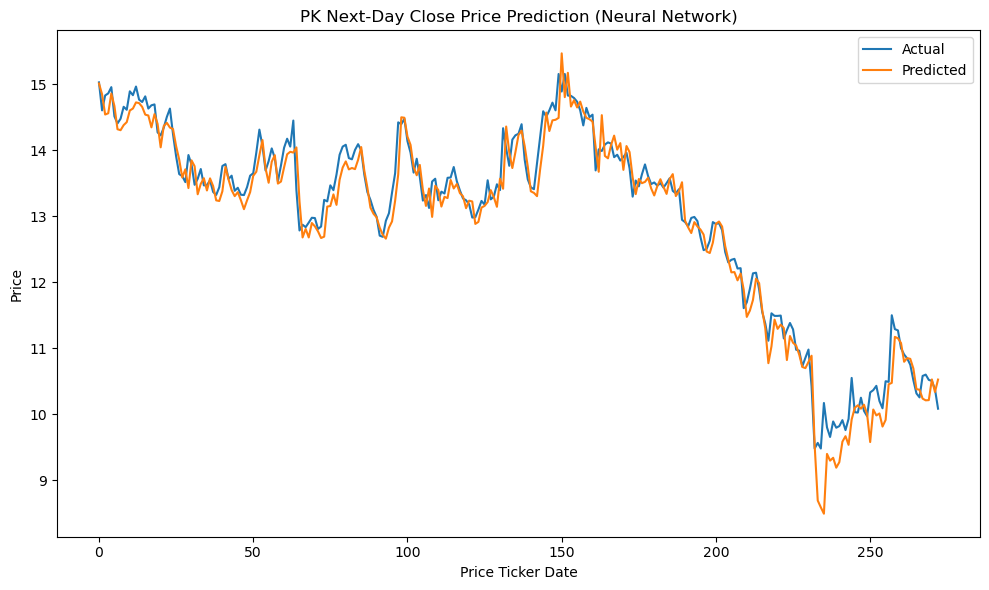

In [158]:
# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(y_test)), y_test.values, label='Actual')
plt.plot(np.arange(len(y_test)), y_pred, label='Predicted')
plt.title(f'{tckr} Next-Day Close Price Prediction (Neural Network)')
plt.xlabel('Price Ticker Date') #('Test Sample Index')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

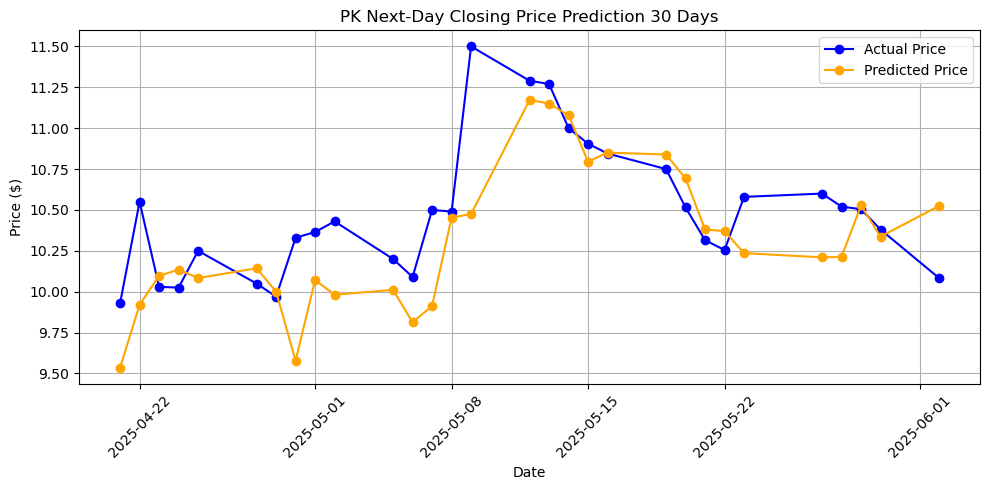

In [159]:
# Extract last 5 days of test predictions and actuals
last_n = 30
y_test_last = y_test[-last_n:]
y_pred_last = y_pred[-last_n:]

# Extract corresponding dates
if isinstance(y_test.index, pd.DatetimeIndex):
    test_dates = y_test.index[-last_n:]
else:
    # fallback if index is not datetime (e.g., RangeIndex)
    test_dates = pd.date_range(end=pd.Timestamp.today(), periods=last_n)

# Plot last week only
plt.figure(figsize=(10, 5))
plt.plot(test_dates, y_test_last.values, label='Actual Price', marker='o', color='blue')
plt.plot(test_dates, y_pred_last, label='Predicted Price', marker='o', color='orange')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.title(f'{tckr} Next-Day Closing Price Prediction {last_n} Days')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [160]:
df

Price,Open,High,Low,Close,Volume,Next_High
Ticker,PK,PK,PK,PK,PK,
Date,,,,,,
2020-01-02,18.614995,18.614995,18.063917,18.071074,2026400,18.146218
2020-01-03,17.892149,18.146218,17.820581,18.114012,2524300,18.013819
2020-01-06,17.942250,18.013819,17.691760,17.706074,1641900,17.634504
2020-01-07,17.591563,17.634504,17.348230,17.412642,2360600,17.498524
2020-01-08,17.391170,17.498524,17.298131,17.477053,2611400,17.527150
...,...,...,...,...,...,...
2025-05-27,10.370000,10.580000,10.165000,10.560000,6929400,10.600000
2025-05-28,10.600000,10.600000,10.380000,10.380000,6398000,10.520000
